1. Setup

In [1]:
# Importing necessary libraries

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error 


In [2]:
# configuring plotting style
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format",lambda x: f'{x:.3f}')

plt.rcParams.update({"axes.titlesize": 10, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize":8})

RANDOM_STATE = 42
CSV_PATH = "housing.csv"
TARGET_COL = "median_house_value"



2. Load Data 

In [3]:
# Loading the dataset

df = pd.read_csv(CSV_PATH)

print("Dataframe shape:", df.shape)

Dataframe shape: (20640, 10)


In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY


3. EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Identifying numerical and categorical columns

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Target column", TARGET_COL)

Numerical columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns: ['ocean_proximity']
Target column median_house_value


In [7]:
# missing values in each column

print("Missing values in each column:\n", df.isnull().sum())


Missing values in each column:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [8]:
# checking for presence of encoded missing values
for col in df.columns:
    print(df[col].value_counts().head(20))

longitude
-118.310    162
-118.300    160
-118.290    148
-118.270    144
-118.320    142
-118.280    141
-118.350    140
-118.360    138
-118.190    135
-118.250    128
-118.370    128
-118.200    126
-118.140    125
-118.260    121
-118.130    121
-118.180    120
-118.340    119
-118.210    118
-118.150    116
-118.120    112
Name: count, dtype: int64
latitude
34.060    244
34.050    236
34.080    234
34.070    231
34.040    221
34.090    212
34.020    208
34.100    203
34.030    193
33.930    181
33.940    175
33.970    172
33.990    168
33.880    164
33.980    162
34.110    162
34.160    159
34.120    158
34.150    157
34.010    156
Name: count, dtype: int64
housing_median_age
52.000    1273
36.000     862
35.000     824
16.000     771
17.000     698
34.000     689
26.000     619
33.000     615
18.000     570
25.000     566
32.000     565
37.000     537
15.000     512
19.000     502
27.000     488
24.000     478
30.000     476
28.000     471
20.000     465
29.000     461
Name: coun

In [9]:
# checking for duplicates

duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [10]:
# descriptive statistics
df[num_cols].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000,20640.000,20640.000,20640.000,20433.000,20640.000,20640.000,20640.000,20640.000
mean,-119.570,35.632,28.639,2635.763,537.871,1425.477,499.540,3.871,206855.817
std,2.004,2.136,12.586,2181.615,421.385,1132.462,382.330,1.900,115395.616
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,14999.000
25%,-121.800,33.930,18.000,1447.750,296.000,787.000,280.000,2.563,119600.000
50%,-118.490,34.260,29.000,2127.000,435.000,1166.000,409.000,3.535,179700.000
75%,-118.010,37.710,37.000,3148.000,647.000,1725.000,605.000,4.743,264725.000
max,-114.310,41.950,52.000,39320.000,6445.000,35682.000,6082.000,15.000,500001.000


4. Data Visualization

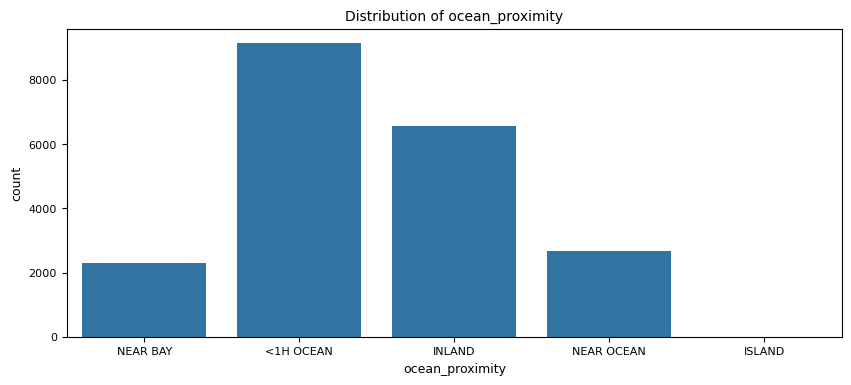

In [11]:
# plot for categorical column
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

In [12]:
for col in cat_cols:
    print(df[col].value_counts().head(10))

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


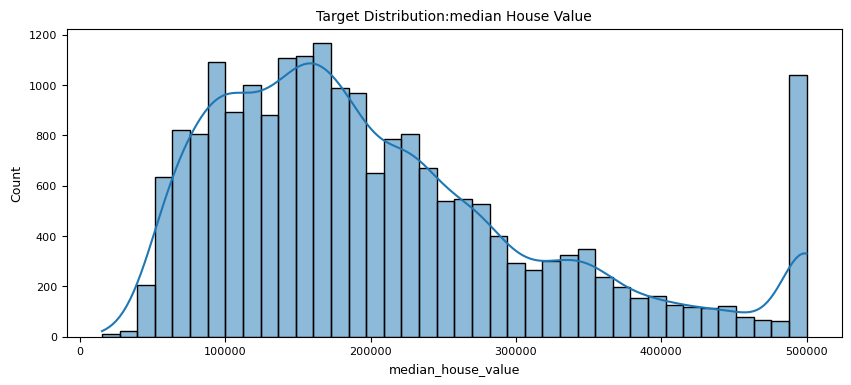

In [13]:
# target column distribution
plt.figure(figsize=(10, 4))
sns.histplot(df[TARGET_COL], bins=40, kde=True)
plt.title("Target Distribution:median House Value")
plt.show()

In [14]:
df[TARGET_COL].value_counts()

median_house_value
500001.000    965
137500.000    122
162500.000    117
112500.000    103
187500.000     93
             ... 
34200.000       1
46200.000       1
352000.000      1
307900.000      1
385200.000      1
Name: count, Length: 3842, dtype: int64

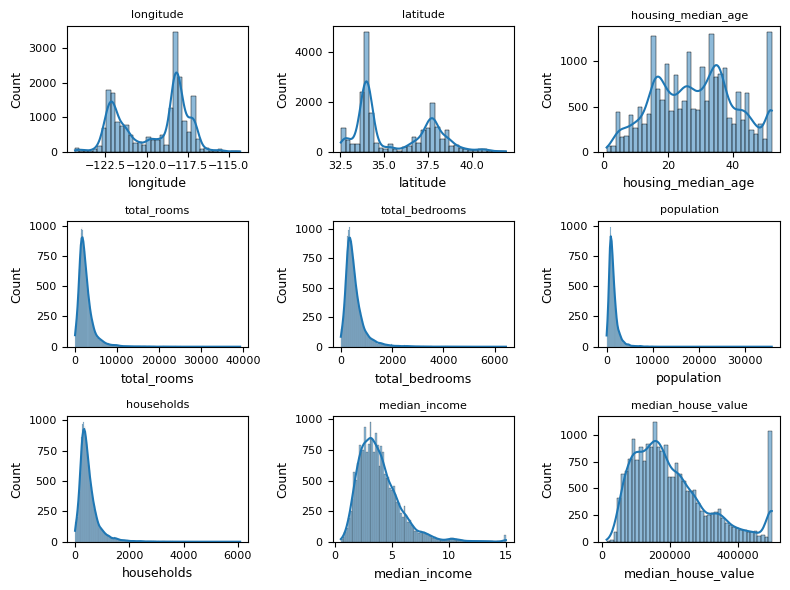

In [15]:
# histogram for numerical column
fig, axes = plt.subplots(3,3, figsize=(8,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col, fontsize=8)

plt.tight_layout()
plt.show()

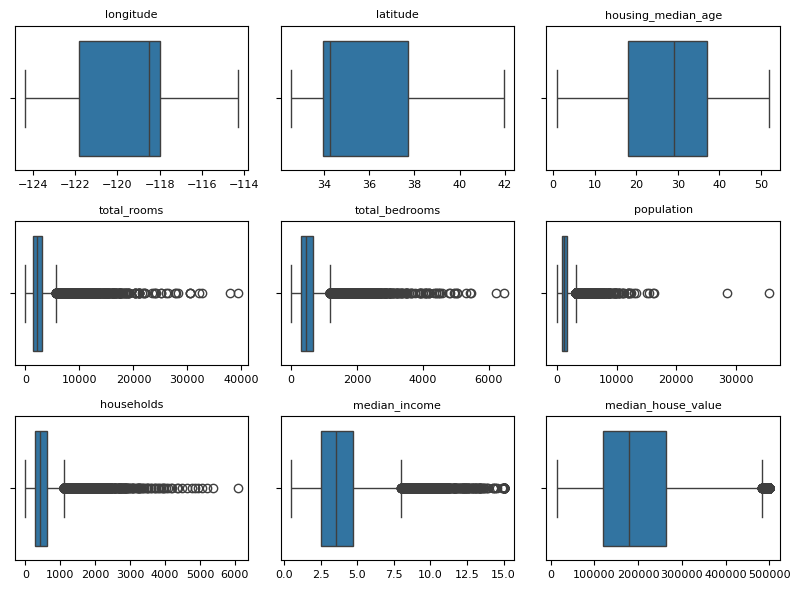

In [16]:
# outlier analysis
fig, axes = plt.subplots(3,3, figsize=(8,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()


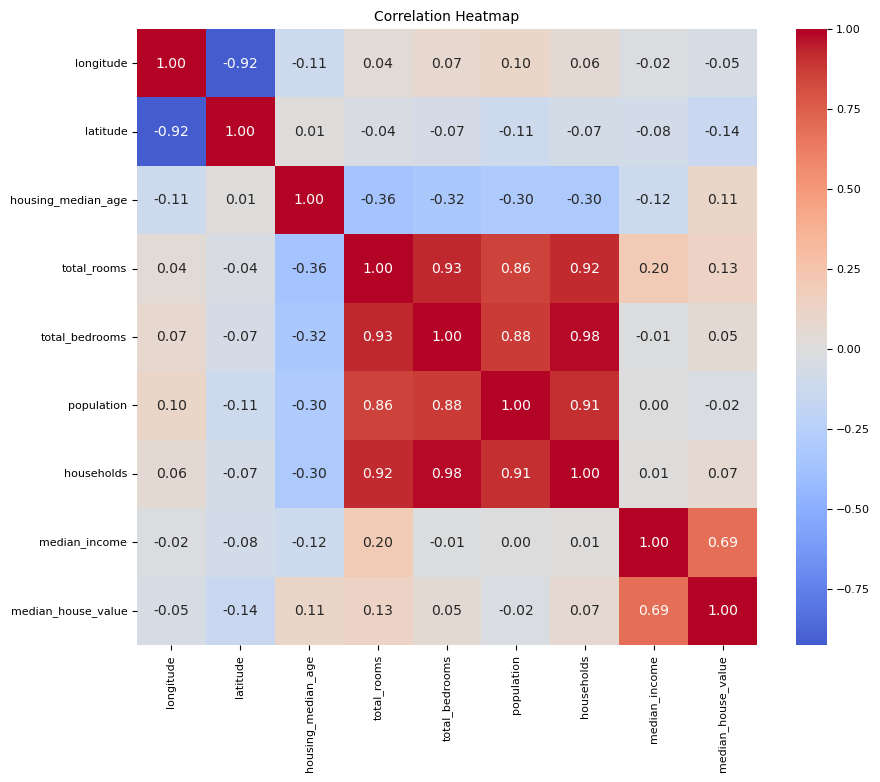

In [17]:
# identify presence of highly correlated columns & feature relationships
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center = 0)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# correlation with target 
corr_with_target = df[num_cols].corr()[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation with target")
print(corr_with_target)


Correlation with target
median_house_value    1.000
median_income         0.688
total_rooms           0.134
housing_median_age    0.106
households            0.066
total_bedrooms        0.050
population           -0.025
longitude            -0.046
latitude             -0.144
Name: median_house_value, dtype: float64


Key Insights from EDA

Dataset has numeric + one categorical feature (ocean_proximity)
Only total_bedrooms has missing values
Target (median_house_value) is right-skewed and capped
Several features show strong skew and outliers
median_income is the strongest predictor
High multicollinearity among room and population feature

🛠️ Preprocessing & Evaluation Plan

Median imputation for missing values
One-hot encoding for categorical feature
Feature scaling for linear models
Use pipelines to avoid data leakage
Baseline model → CV model selection → hyperparameter tuning
Primary metric: RMSE, secondary: MAE and R²
Final evaluation only on test set

4. Data Preprocessing


In [19]:
# separate features and target 
x = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [20]:
x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,NEAR BAY
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,NEAR BAY
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,NEAR BAY
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,NEAR BAY
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,NEAR BAY


In [21]:
y.head()

0   452600.000
1   358500.000
2   352100.000
3   341300.000
4   342200.000
Name: median_house_value, dtype: float64

In [22]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=RANDOM_STATE
)

In [23]:
print("Train shape", x_train.shape)
print("Test shape", x_test.shape)

Train shape (16512, 9)
Test shape (4128, 9)


 Preprocessing Pipline

In [24]:
from sklearn.compose import ColumnTransformer

numerical_features = x_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = x_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Preprocessing pipelines for numerical and categorical features

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# preprocessing pipeline for all features
preprocess = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)   

Numerical features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Categorical features: ['ocean_proximity']


5. Model

In [25]:
baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

In [26]:
# fitting the baseline model
baseline_pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('model', LinearRegression())])

In [27]:
# Evaluation of the baseline model

train_baseline_pred = baseline_pipe.predict(x_train)
test_baseline_pred = baseline_pipe.predict(x_test)

In [28]:
train_baseline_pred[:5]

array([188628.0772436 , 290379.8948687 , 250985.48476349, 146878.07878194,
       165789.41368924])

In [29]:
y_train[:5]

14196   103000.000
8267    382100.000
17445   172600.000
14265    93400.000
2271     96500.000
Name: median_house_value, dtype: float64

In [30]:
train_base_rmse = root_mean_squared_error(y_train, train_baseline_pred)
train_baseline_mae = mean_absolute_error(y_train, train_baseline_pred)
train_baseline_r2 = r2_score(y_train, train_baseline_pred)

print("\nBaseline Model Performance on Training Set(Linear Regression):")
print(f"RMSE: {train_base_rmse:.3f}")
print(f"MAE: {train_baseline_mae:.3f}")
print(f"R²: {train_baseline_r2:.3f}")


Baseline Model Performance on Training Set(Linear Regression):
RMSE: 68433.937
MAE: 49594.842
R²: 0.650


In [31]:
test_baseline_rmse = root_mean_squared_error(y_test, test_baseline_pred)
test_baseline_mae = mean_absolute_error(y_test, test_baseline_pred)
test_baseline_r2 = r2_score(y_test, test_baseline_pred)

print("\nBaseline Model Performance on Test Set(Linear Regression):")
print(f"RMSE: {test_baseline_rmse:.3f}")
print(f"MAE: {test_baseline_mae:.3f}")
print(f"R²: {test_baseline_r2:.3f}")


Baseline Model Performance on Test Set(Linear Regression):
RMSE: 70059.193
MAE: 50670.489
R²: 0.625


6. Model selection and Optimization

In [32]:
# possible models to try:

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE),
    "Random Forest": RandomForestRegressor(),
    "Hist Gradient Boosting": HistGradientBoostingRegressor()
}

In [33]:
k = 5 
cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)


In [34]:
scoring = {
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R²": "r2"
}

In [35]:
rows = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    
    scores = cross_validate(pipe, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    
    row = {
        "Model": name,
        "CV RMSE": -scores["test_RMSE"].mean(),
        "CV MAE": -scores["test_MAE"].mean(),
        "CV R²": scores["test_R²"].mean()
    }
    rows.append(row)  # ✅ Add this line

# sort based on lowest rmse value 
cv_results = pd.DataFrame(rows).sort_values(by="CV RMSE")
print("\nCross-Validation Results:")
print(cv_results)




Cross-Validation Results:
                    Model   CV RMSE    CV MAE  CV R²
4  Hist Gradient Boosting 48044.516 32287.861  0.827
3           Random Forest 49382.155 32254.414  0.818
1                   Ridge 68595.617 49664.331  0.648
2                   Lasso 68603.241 49667.266  0.648
0       Linear Regression 68604.163 49667.159  0.648


In [36]:
best_row = cv_results.sort_values(by="CV RMSE").iloc[0]


best_model_name = best_row["Model"]
best_rmse = best_row["CV RMSE"]

print(f"\nBest model based on CV RMSE: {best_model_name}")
print(f"Best RMSE value: {best_rmse}")


Best model based on CV RMSE: Hist Gradient Boosting
Best RMSE value: 48044.515664448896


7. Hyperparameter Tuning

In [37]:
hgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("model", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

In [38]:
# hyperparameters combination
param_grid = {
    "model__learning_rate": [0.01,0.03,0.05, 0.1],
    "model__max_depth": [None,3, 5,6],
    "model__max_leaf_nodes": [None,15,20,31, 50,63],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0, 0.1, 0.5, 1.0]
}   

In [39]:
grid = GridSearchCV(estimator=hgb_pipe, param_grid=param_grid, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_income'...
                                                                         ['ocean_proximity'])])),
                                       ('model',
                                        HistGradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__l2_regularization': [0, 0.1, 0.5, 1.0],
                         'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
                         'model__max_depth': [None, 3, 5, 6],
                         'model__max_leaf_nodes': [None, 15, 20, 31, 50, 63],
                         'model__min_samples_leaf': [20, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [40]:
print("\n === TUNED HGB MODEL PERFORMANCE ===")
print("Best parameters:", grid.best_params_)
print("Best cross-validation rmse score:", -grid.best_score_)


 === TUNED HGB MODEL PERFORMANCE ===
Best parameters: {'model__l2_regularization': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__max_leaf_nodes': 63, 'model__min_samples_leaf': 20}
Best cross-validation rmse score: 47408.38131673431


8. Retraining with best params

In [41]:
hgb_best = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=None,
        max_leaf_nodes=63,
        min_samples_leaf=20,
        l2_regularization=0.1,
    ))
])  

In [42]:
# fitting the best model on the training data
hgb_best.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=0.1,
                                               max_leaf_nodes=63))])

9. Final Evaluation

In [43]:
train_final_pred = hgb_best.predict(x_train)

train_final_rmse = root_mean_squared_error(y_train, train_final_pred)
train_final_mae = mean_absolute_error(y_train, train_final_pred)
train_final_r2 = r2_score(y_train, train_final_pred)

print("\nFinal Model Performance on Training Set(Hist Gradient Boosting):")
print(f"RMSE: {train_final_rmse:.3f}")
print(f"MAE: {train_final_mae:.3f}")
print(f"R²: {train_final_r2:.3f}")


Final Model Performance on Training Set(Hist Gradient Boosting):
RMSE: 36036.492
MAE: 24533.258
R²: 0.903


In [44]:
test_final_pred = hgb_best.predict(x_test)


test_final_rmse = root_mean_squared_error(y_test, test_final_pred)  
test_final_mae = mean_absolute_error(y_test, test_final_pred)
test_final_r2 = r2_score(y_test, test_final_pred)

print("\nFinal Model Performance on Test Set(Hist Gradient Boosting):")
print(f"RMSE: {test_final_rmse:.3f}")
print(f"MAE: {test_final_mae:.3f}")
print(f"R²: {test_final_r2:.3f}")




Final Model Performance on Test Set(Hist Gradient Boosting):
RMSE: 46384.417
MAE: 30851.610
R²: 0.836


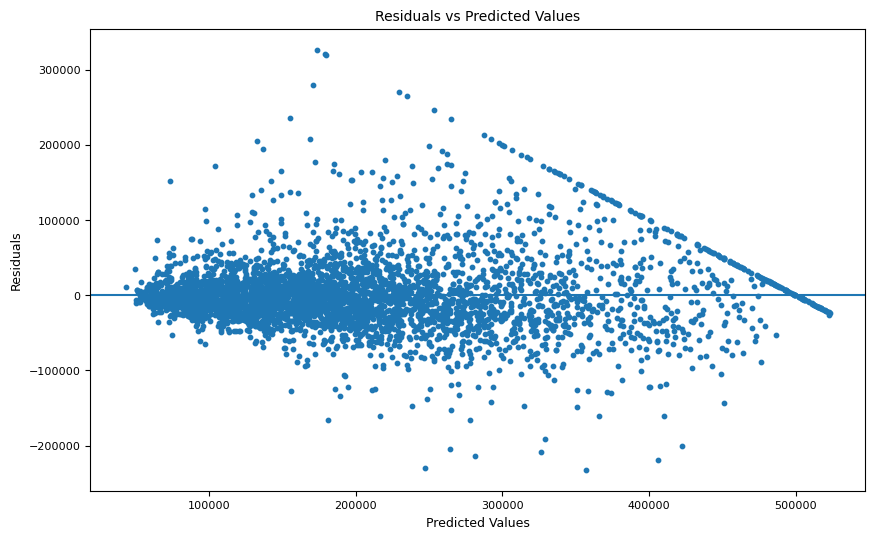

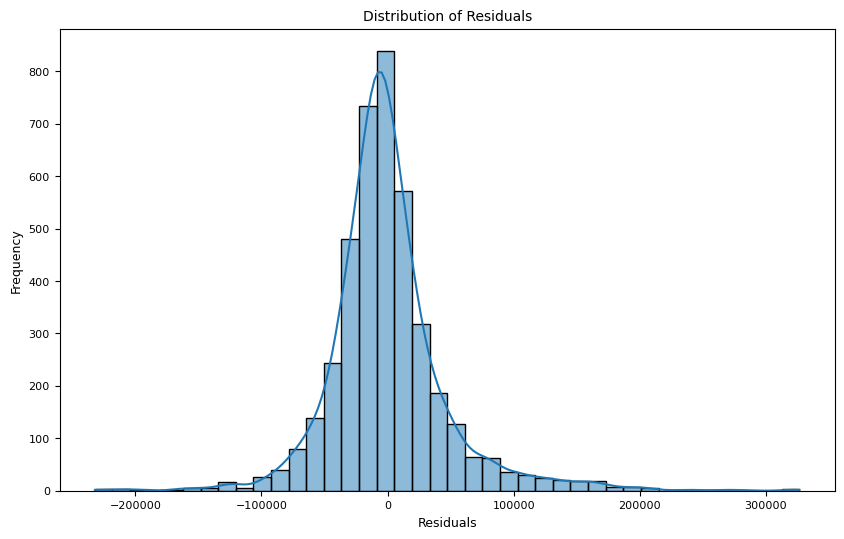

In [45]:
# residual analysis
residuals = y_test - test_final_pred

plt.figure(figsize=(10, 6))
plt.scatter(test_final_pred, residuals, s=10)
plt.axhline(0)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()




10. Building a predictive system

In [46]:
def predict_house_price(model, longitude :float, latitude :float, housing_median_age :float, total_rooms :float, total_bedrooms :float, population :float, households :float, median_income :float, ocean_proximity :str)-> float:

    """Predict median_house_value for one new house. total_bedrooms can be np.nan(pipeline will impute)."""
    new_row = pd.DataFrame({
        "longitude": [longitude],  
        "latitude": [latitude],
        "housing_median_age": [housing_median_age],
        "total_rooms": [total_rooms],
        "total_bedrooms": [total_bedrooms],
        "population": [population],
        "households": [households],
        "median_income": [median_income],
        "ocean_proximity": [ocean_proximity]
    })

    return float(model.predict(new_row)[0])

In [47]:
# Example usage:
example_pred = predict_house_price(
    model=hgb_best,
    longitude=-122.23,
    latitude=37.88,
    housing_median_age=41.0,
    total_rooms=880.0,
    total_bedrooms=129.0,
    population=322.0,
    households=126.0,
    median_income=8.3252,
    ocean_proximity="NEAR BAY"
)

print(f"Predicted median house value for the example input: ${example_pred:.2f}")

Predicted median house value for the example input: $436079.34
